In [4]:
# Disabling future release version warnings 
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from scipy.stats import anderson, kstest, shapiro

In [6]:
file = "sleep_merged.csv"

In [7]:
data = pd.read_csv(file)

In [8]:
df = copy.deepcopy(data)

In [9]:
cols = df.columns

In [10]:
cols

Index(['Species', 'Genus', 'Order', 'Vore', 'Conservation', 'BodyWt',
       'BrainWt', 'TotalSleep', 'Awake', 'NonDreaming', 'Dreaming', 'LifeSpan',
       'Gestation', 'Predation', 'Exposure', 'Danger'],
      dtype='object')

#### Vore column encoding  

In [11]:
df = pd.get_dummies(df, columns=["Vore"], prefix=["Vore"], drop_first=True)


In [12]:
df[["Vore_insecti","Vore_herbi","Vore_omni"]] = df[["Vore_insecti","Vore_herbi","Vore_omni"]].astype(int)


In [13]:
df["Vore"] = data["Vore"]

In [14]:
cols = df.columns

In [15]:
df.head()

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,Vore_herbi,Vore_insecti,Vore_omni,Vore
0,Cheetah,Acinonyx,Carnivora,lc,50.000,0.0,12.1,11.9,NaN,NaN,20.0,93.0,NaN,NaN,NaN,0,0,0,carni
1,Northern fur seal,Callorhinus,Carnivora,vu,20.490,0.0,8.7,15.3,NaN,1.4,26.0,358.0,NaN,NaN,NaN,0,0,0,carni
2,Lion,Panthera,Carnivora,vu,161.499,0.0,13.5,10.5,NaN,NaN,20.0,115.0,NaN,NaN,NaN,0,0,0,carni
3,Tiger,Panthera,Carnivora,en,162.564,0.0,15.8,8.2,NaN,NaN,23.0,112.0,NaN,NaN,NaN,0,0,0,carni
4,Caspian seal,Phoca,Carnivora,vu,86.000,0.0,3.5,20.5,NaN,0.4,35.0,334.0,NaN,NaN,NaN,0,0,0,carni


# Visualization

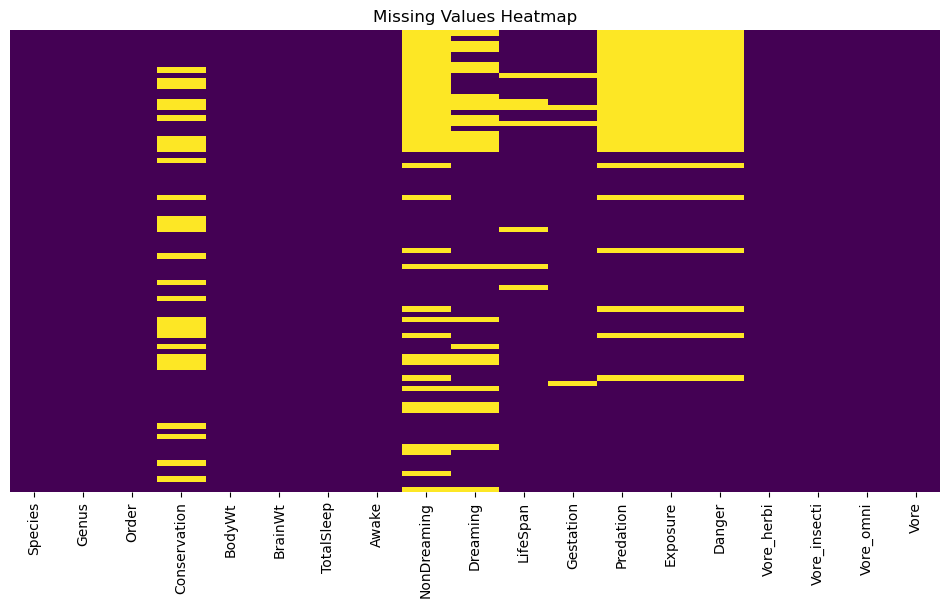

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

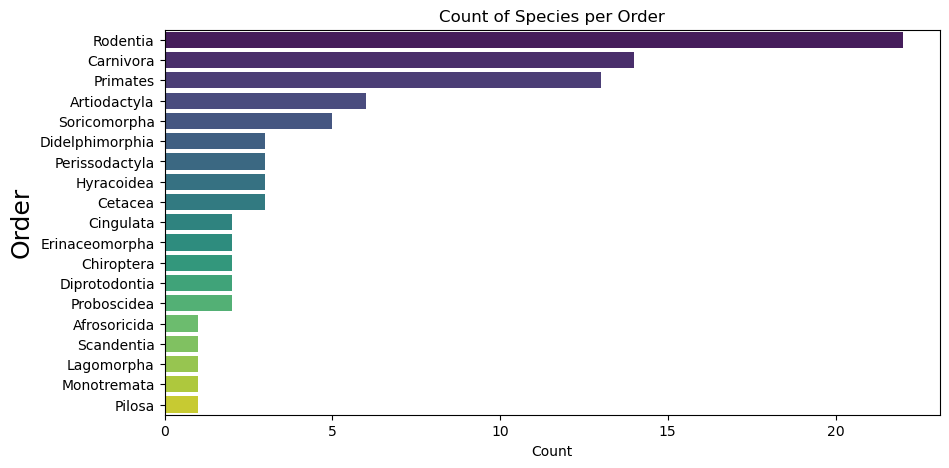

In [17]:
# Count of species per Order
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='Order',order=df["Order"].value_counts().index, palette="viridis")
plt.title('Count of Species per Order')
plt.xlabel('Count')
plt.ylabel('Order', fontsize=18)
plt.show()

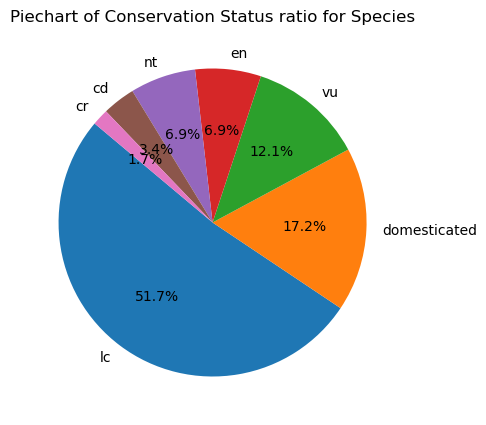

In [18]:
# Conservation status
plt.figure(figsize=(5, 5))
df['Conservation'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Piechart of Conservation Status ratio for Species')
plt.ylabel('')
plt.show()

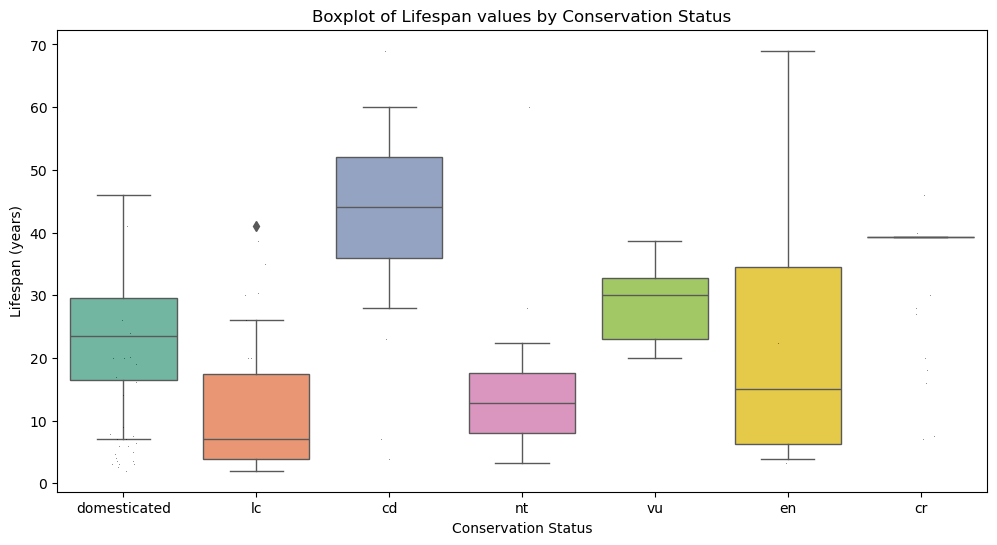

In [19]:
# Boxplot of Lifespan by Conservation status
order = ["domesticated","lc","cd","nt","vu","en","cr"]

plt.figure(figsize=(12, 6)) 
sns.boxplot(data=df, x='Conservation', y='LifeSpan', linewidth=1, palette="Set2", showfliers=True, order=order)
sns.stripplot(data= df , y="LifeSpan", x = "Conservation",color="black", size=0.4)

plt.title('Boxplot of Lifespan values by Conservation Status')
plt.xlabel('Conservation Status')
plt.ylabel('Lifespan (years)')
plt.show()

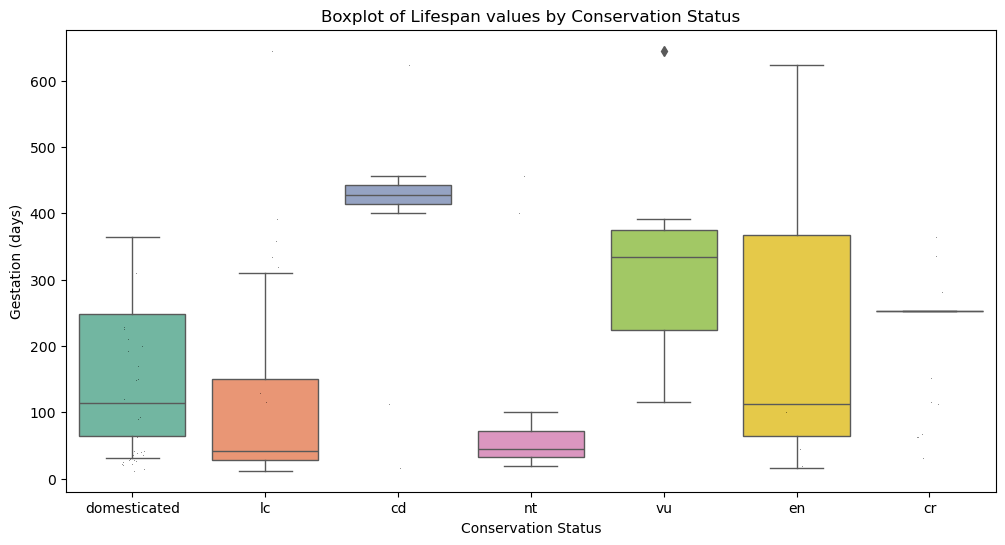

In [20]:
# Boxplot of Gestation by Conservation status
order = ["domesticated","lc","cd","nt","vu","en","cr"]

plt.figure(figsize=(12, 6)) 
sns.boxplot(data=df, x='Conservation', y='Gestation', linewidth=1, palette="Set2", showfliers=True, order=order)
sns.stripplot(data= df , y="Gestation", x = "Conservation",color="black", size=0.4)

plt.title('Boxplot of Lifespan values by Conservation Status')
plt.xlabel('Conservation Status')
plt.ylabel('Gestation (days)')
plt.show()

##### there seemed to be a dependency between cd and gestation , but cd has only 2 records

In [21]:
print(df[df["Conservation"] == "cd"])

        Species          Genus         Order Conservation   BodyWt  BrainWt  \
5   Pilot whale  Globicephalus       Cetacea           cd  800.000      0.0   
83      Giraffe        Giraffa  Artiodactyla           cd  899.995    680.0   

    TotalSleep  Awake  NonDreaming  Dreaming  LifeSpan  Gestation  Predation  \
5          2.7  21.35          NaN       0.1      60.0      456.0        NaN   
83         1.9  22.10          NaN       0.3      28.0      400.0        5.0   

    Exposure  Danger  Vore_herbi  Vore_insecti  Vore_omni   Vore  
5        NaN     NaN           0             0          0  carni  
83       5.0     5.0           1             0          0  herbi  


In [22]:
df["Conservation_count"] = df.groupby("Conservation")["Conservation"].transform("count")

<Axes: xlabel='count', ylabel='Conservation'>

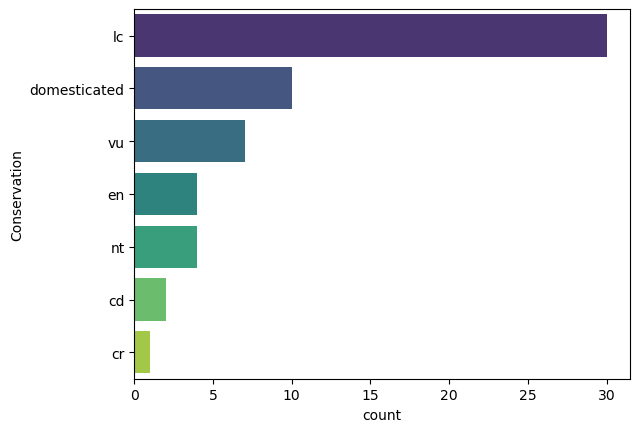

In [23]:
sns.countplot(data=df, y="Conservation", order=df['Conservation'].value_counts().index, palette="viridis")

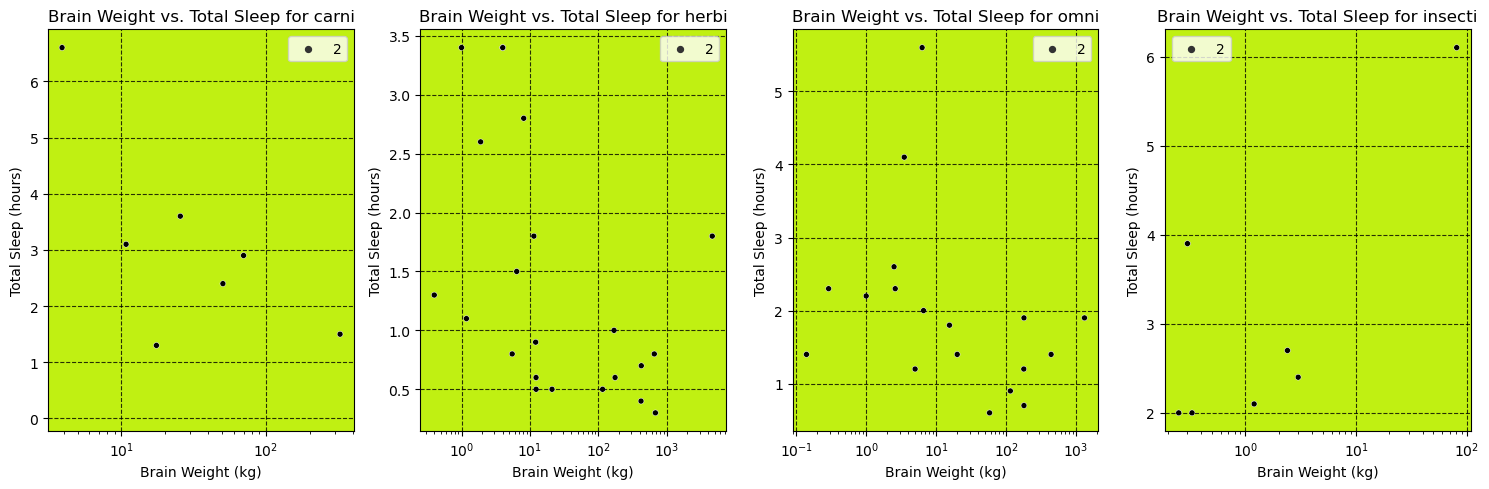

In [24]:
unique_vore = df["Vore"].unique()

# Create subplots
fig, axes = plt.subplots(1, len(unique_vore), figsize=(15, 5))
# Loop through each unique value in "Vore" and create scatter plots
for i, diet in enumerate(unique_vore):
    dff = df[df["Vore"] == diet]
    ax = axes[i]
    sns.scatterplot(data=dff, x='BrainWt', y='Dreaming', ax=ax, marker="o", size=2, color='black')
    ax.set_title(f"Brain Weight vs. Total Sleep for {diet}")
    ax.set_xlabel('Brain Weight (kg)')
    ax.set_ylabel('Total Sleep (hours)')
    ax.set_xscale('log')

    ax.set_facecolor('#C0F012')  # Dark background
    ax.grid(True, linestyle='--', alpha=0.8, color="black")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

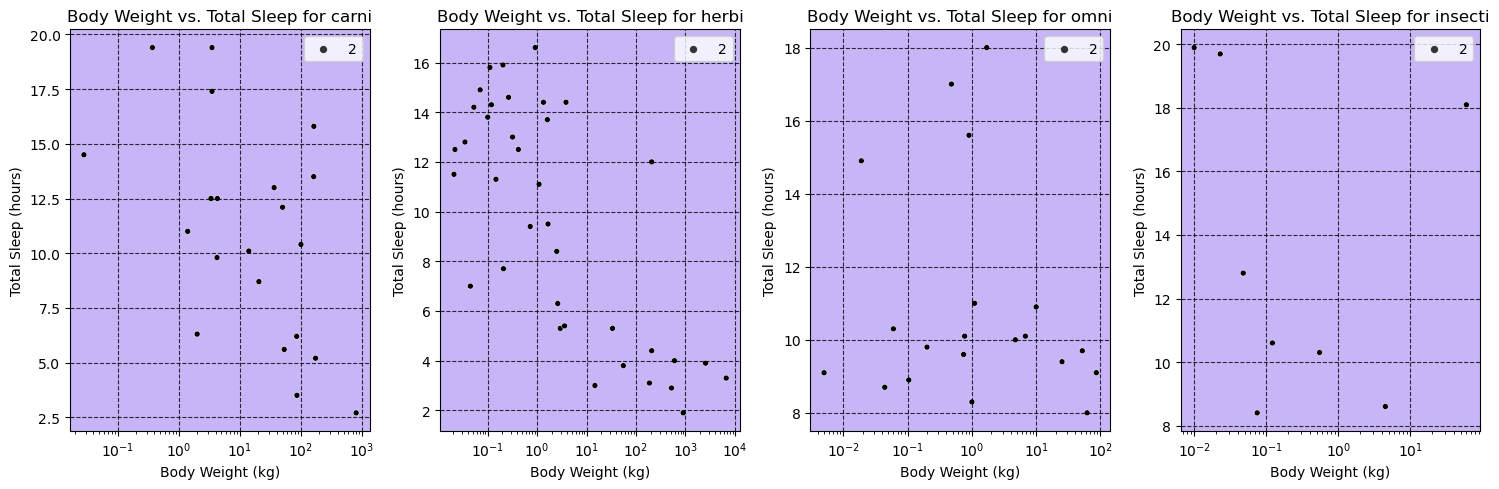

In [25]:
unique_vore = df["Vore"].unique()

# Create subplots
fig, axes = plt.subplots(1, len(unique_vore), figsize=(15, 5))

# Loop through each unique value in "Vore" and create scatter plots
for i, diet in enumerate(unique_vore):
    dff = df[df["Vore"] == diet]
    ax = axes[i]
    sns.scatterplot(data=dff, x='BodyWt', y='TotalSleep', ax=ax, marker="o", size=2, color='black')
    ax.set_title(f"Body Weight vs. Total Sleep for {diet}")
    ax.set_xlabel('Body Weight (kg)')
    ax.set_ylabel('Total Sleep (hours)')
    ax.set_xscale('log')

    ax.set_facecolor('#C7B5F7')  # Dark background
    ax.grid(True, linestyle='--', alpha=0.8, color="black")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

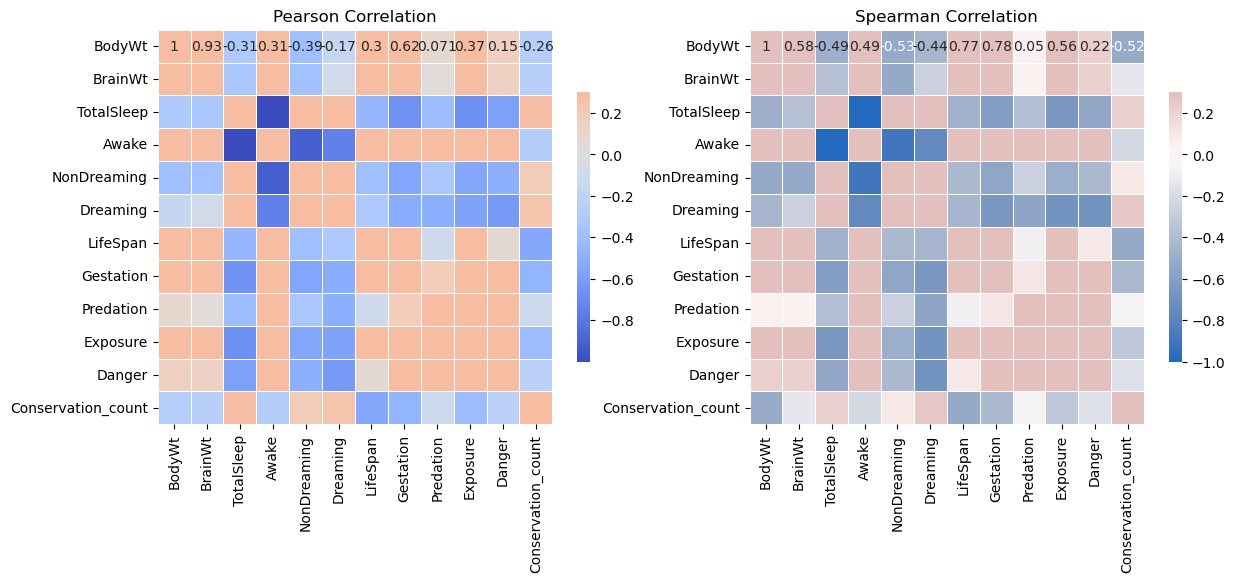

In [26]:
# Filtering only numerical columns for correlation matrix
num_df = df.select_dtypes(include=["float", "int"])
num_df = num_df.drop(["Vore_herbi","Vore_insecti","Vore_omni"], axis=1)

# Create subplots with two columns to display two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Calculate and draw the Pearson correlation heatmap
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm',
            vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[0])
axes[0].set_title("Pearson Correlation")

# Calculate and draw the Spearman correlation heatmap
sns.heatmap(num_df.corr(method='spearman'), annot=True, cmap='vlag',
            vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[1])
axes[1].set_title("Spearman Correlation")

# Display the plot
plt.show()


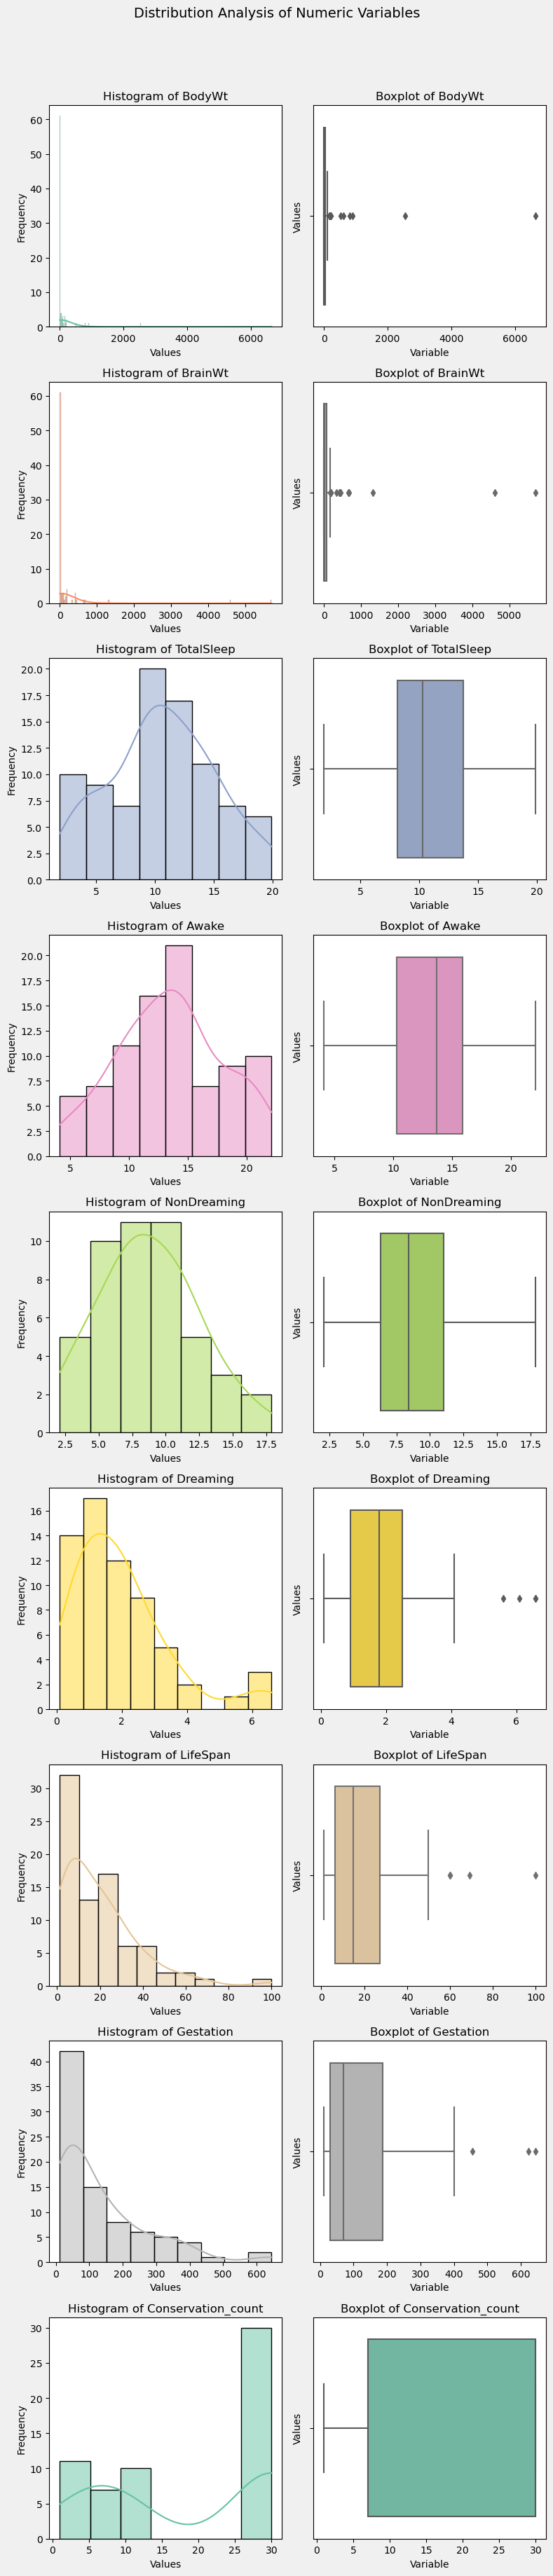

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric columns to plot
numeric_cols = [col for col in df.columns if df[col].dtype in ["float64", "int64"] and col not in ['Predation', 'Exposure', 'Danger']]

# Define a color palette for the plots
color_palette = sns.color_palette("Set2", len(numeric_cols))

# Create a figure for the subplots with a smaller size and non-white background
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(8, 4 * len(numeric_cols)))  # Adjust figsize
fig.set_facecolor('#f0f0f0')  # Set background color to light gray

for i, col in enumerate(numeric_cols):
    # Plot the histogram on the left (first column)
    sns.histplot(data=df, x=col, bins="auto", kde=True, ax=axes[i, 0], color=color_palette[i])
    axes[i, 0].set_title(f"Histogram of {col}")
    axes[i, 0].set_xlabel("Values")
    axes[i, 0].set_ylabel("Frequency")
    
    # Plot the boxplot on the right (second column)
    sns.boxplot(data=df, x=col, ax=axes[i, 1], color=color_palette[i])
    axes[i, 1].set_title(f"Boxplot of {col}")
    axes[i, 1].set_xlabel("Variable")
    axes[i, 1].set_ylabel("Values")

# Add a title to the entire figure
plt.suptitle("Distribution Analysis of Numeric Variables", fontsize=14, y=1.02)  # Adjust fontsize

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

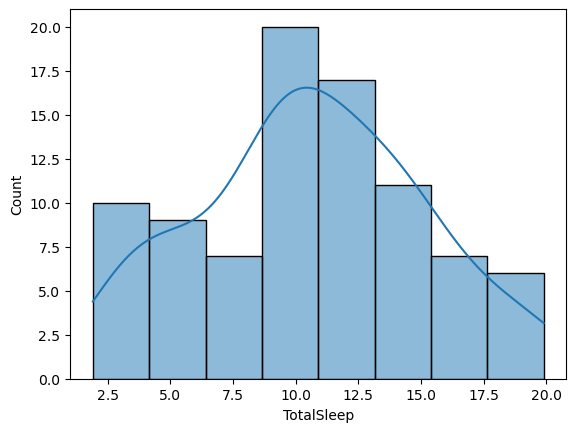

In [28]:
# Histograms for continuous variables
sns.histplot(data['TotalSleep'], kde=True)
plt.show()



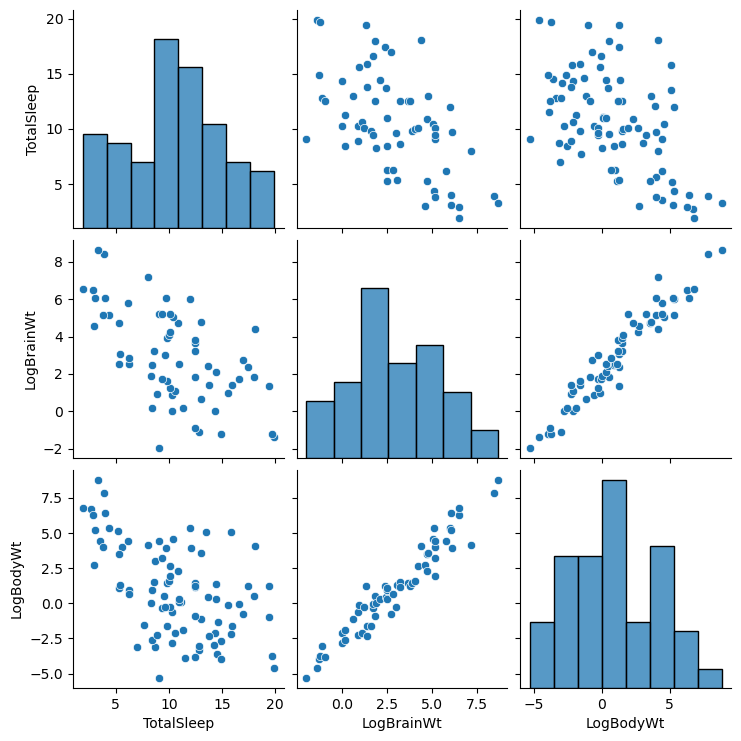

In [29]:
df['LogBrainWt'] = np.log(df['BrainWt'])
df['LogBodyWt'] = np.log(df["BodyWt"])

sns.pairplot(df, vars=["TotalSleep","LogBrainWt","LogBodyWt"])


<Axes: xlabel='BrainBodyRatio', ylabel='TotalSleep'>

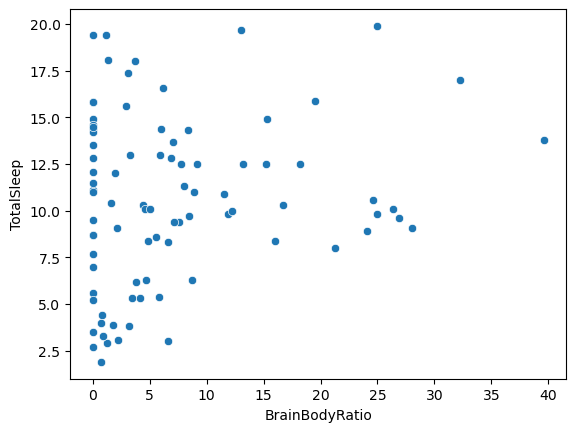

In [30]:

df["BrainBodyRatio"] = df["BrainWt"] / df["BodyWt"]

sns.scatterplot(data=df, x="BrainBodyRatio", y="TotalSleep")

##### I create some useful functions to check for correlations and normality, that we will often need throughout this notebook 

In [31]:
#I define a correlation function that returns the corr a target column has with other columns if corr > t (threshold)
#I use both pearson and spearman because some features are not normally distributed etc.

def corr_func(target: str, t):
    spear_corr = {}
    pears_corr = {}
    for col in cols:
        if df[col].dtype in ["float64", "int64"] and col != target:
            # Pairwise deletion to include only rows where there is no missing values at all in either of the two features
            valid_rows = df[[col, target]].dropna()

            if len(valid_rows) > 0:  # Check if there are valid rows for correlation (since I know the dataset, it's useless here but i still include it)
                correlation, p_value = spearmanr(valid_rows[col], valid_rows[target])
                correlation2 = valid_rows[col].corr(valid_rows[target])
                if abs(correlation) >= t:
                    spear_corr[col] = round(correlation, 2)
                elif abs(correlation2) >= t:
                    pears_corr[col] = round(correlation2, 2)
    print(f"Correlation for {target} : \n\n Spearman correlation is: {spear_corr}", "\n\n", f"Pearson correlation is: {pears_corr}")

    return


##### Here next we will define a function to test not graphically but analyticaly the normality of our features

In [32]:
from scipy.stats import kstest, anderson, norm

def normal_test(feature, alpha):
    result = {}

    # Kstest
    ks_stat, ks_pvalue = kstest(feature, 'norm')
    ks_normal = ks_pvalue > alpha
    result['Kolmogorov-Smirnov'] = {'Statistic': ks_stat, 'p_value': ks_pvalue, 'Normal': ks_normal}

    ''''#Anderson
    ad_statistic, ad_critical_values, ad_significance_level = anderson(feature, dist="norm")
    ad_normal = ad_statistic < ad_critical_values[ad_significance_level == alpha][0]'''
    ##ANDERSON TEST seems to fail unexpectedly, I try to make it work, and to not block the code if it fails


    # Check if the sample size is sufficient for Anderson-Darling
    if len(feature) >= 3:
        try:
            ad_statistic, ad_critical_values, ad_significance_level = anderson(feature, dist="norm")
            ad_normal = ad_statistic < ad_critical_values[ad_significance_level == alpha][0]
            result['Anderson-Darling'] = {'Statistic': ad_statistic, 'Critical Values': ad_critical_values, 'Significance Level': ad_significance_level, 'Normal': ad_normal}
        except (ValueError, IndexError):
            result['Anderson-Darling'] = {'Statistic': None, 'Critical Values': None, 'Significance Level': None, 'Normal': False}
            result['Error'] = 'Anderson-Darling test failed'
    else:
        result['Error'] = 'Insufficient data points for testing'


    return result

##### To assess whether a feature is normal or not, we can run some statistical test, extract their p-value and compare it to the p value cutoff. (we can set it 0.05, higher or lower).

In [33]:
label = df["TotalSleep"].dropna().astype(float)
result = normal_test(label, alpha=0.05)
print(result)

{'Kolmogorov-Smirnov': {'Statistic': 0.9850387733233962, 'p_value': 3.335620642889021e-159, 'Normal': False}, 'Anderson-Darling': {'Statistic': None, 'Critical Values': None, 'Significance Level': None, 'Normal': False}, 'Error': 'Anderson-Darling test failed'}


## Data cleaning

#### We now will fill out the missing values for Predation, Exposure, Danger

In [34]:
df["Predation"] = df["Predation"].fillna(df.groupby("Order")["Predation"].transform("mean").round())
df["Exposure"] = df["Exposure"].fillna(df.groupby("Order")["Exposure"].transform("mean").round())
df["Danger"] = df["Danger"].fillna(df.groupby("Order")["Danger"].transform("mean").round())

##### It seems grouping by vore, gives some clues on the these features as well, so we can see that there is a low std dev of pred, exp, dang, grouped by vore
Notes: Actually grouping by vore was doable at first, but it's a choice. Order and Vore are very much linked, they got the same vore for the same order (almost), sometimes herbi/omni but herbi/omni have almost the same mean. So it's fine and on parallel grouping by order can contain real information other than vore for predation exposure

In [35]:
df["Predation"] = df["Predation"].fillna(df.groupby("Vore")["Predation"].transform("mean").round())
df["Exposure"] = df["Exposure"].fillna(df.groupby("Vore")["Exposure"].transform("mean").round())
df["Danger"] = df["Danger"].fillna(df.groupby("Vore")["Danger"].transform("mean").round())

#### Here we will correct the 0 values found in the BrainWt feature that should not be 0

In [36]:
df["BrainWt"] = df["BrainWt"].replace(0, np.nan)

In [37]:
df_model = df[["BodyWt","BrainWt"]].dropna()

In [38]:
spearman_corr, p_value = spearmanr(df_model["BodyWt"],df_model["BrainWt"])
print(spearman_corr)
print(p_value)

0.95426707170921
3.245340518275321e-34


##### We train a linear regression model to fill out the 0 values fo brain weight based on body weight

In [39]:
feature = df_model["BodyWt"].values.reshape(-1,1)
target = df_model["BrainWt"].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.1, random_state = 11)

In [40]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [41]:
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)
print(mse, r2)

7410.142884760871 0.3269973287388068


##### We do the regression imputation

In [42]:
df_model_null = df[df["BrainWt"].isnull()]
df_model_complete = df[-df["BrainWt"].isnull()]

model = LinearRegression()

# Train the model using the complete data
X = df_model_complete["BodyWt"].values.reshape(-1, 1)
y = df_model_complete["BrainWt"].values
model.fit(X, y)

# Use the trained model to predict "BrainWt" for the missing values
X_predict = df_model_null["BodyWt"].values.reshape(-1, 1)
y_pred = model.predict(X_predict)
y_pred = np.maximum(y_pred, 0)

#rounding
y_pred = np.round(y_pred,2)
# Replace the missing "BrainWt" values with the predicted values
df.loc[df["BrainWt"].isnull(), "BrainWt"] = y_pred

#### Dealing with remaining NA in Gestation using brainwt, bodywt, totalsleep

##### We going to fill some LifeSpan rows where gestation is available using regression imputation again

In [43]:
corr_func("LifeSpan",0)

Correlation for LifeSpan : 

 Spearman correlation is: {'BodyWt': 0.77, 'BrainWt': 0.76, 'TotalSleep': -0.47, 'Awake': 0.47, 'NonDreaming': -0.42, 'Dreaming': -0.44, 'Gestation': 0.76, 'Predation': -0.26, 'Exposure': 0.5, 'Danger': -0.09} 

 Pearson correlation is: {}


In [44]:
# We going to fill some LifeSpan rows where gestation is available
df_model = df.dropna()
df_model_features = df_model[["BrainWt", "TotalSleep","Gestation"]]
df_model_target = df_model[["LifeSpan"]]

X_train, X_test, y_train, y_test = train_test_split(df_model_features, df_model_target, test_size = 0.1, random_state = 11)
y_train = y_train.values.reshape(-1,1)
model = LinearRegression()
model.fit(X_train, y_train)

df_model_features_test = df[df["LifeSpan"].isnull() & -df["Gestation"].isnull()]
X_test = df_model_features_test[["BrainWt","TotalSleep","Gestation"]]

y_pred = model.predict(X_test)
df.loc[df["LifeSpan"].isnull() & -df["Gestation"].isnull(), "LifeSpan"] = y_pred
df["LifeSpan"] = np.round(df["LifeSpan"],1)

#### We going to FULLY fill out Gestation missing values through regression imputation

In [45]:
corr_func("Gestation",0.5)

Correlation for Gestation : 

 Spearman correlation is: {'BodyWt': 0.78, 'BrainWt': 0.74, 'TotalSleep': -0.62, 'Awake': 0.62, 'NonDreaming': -0.55, 'Dreaming': -0.65, 'LifeSpan': 0.76, 'Exposure': 0.57} 

 Pearson correlation is: {}


In [46]:
# We going to FULLY fill out Gestation missing values through regression imputation
df_model = df.dropna()
df_model_features = df_model[["BodyWt","BrainWt", "TotalSleep"]]
df_model_target = df_model[["Gestation"]]

X_train, X_test, y_train, y_test = train_test_split(df_model_features, df_model_target, test_size = 0.1, random_state = 11)
y_train = y_train.values.reshape(-1,1)
model = LinearRegression()
model.fit(X_train, y_train)

df_model_features_test = df[df["Gestation"].isnull()]
X_test = df_model_features_test[["BodyWt","BrainWt", "TotalSleep"]]

y_pred = model.predict(X_test)
gestation_minimum = df["Gestation"].min()
y_pred = np.round(np.maximum(y_pred, gestation_minimum),1)
df.loc[df["Gestation"].isnull(), "Gestation"] = y_pred
df["Gestation"] = np.round(df["Gestation"],1)

#### We going to fill the remaining LifeSpan rows now that all gestation is available

In [47]:
# We going to fill the remaining LifeSpan rows now that all gestation is available
df_model = df.dropna()
df_model_features = df_model[["BrainWt", "TotalSleep","Gestation"]]
df_model_target = df_model[["LifeSpan"]]

X_train, X_test, y_train, y_test = train_test_split(df_model_features, df_model_target, test_size = 0.1, random_state = 11)
y_train = y_train.values.reshape(-1,1)
model = LinearRegression()
model.fit(X_train, y_train)

df_model_features_test = df[df["LifeSpan"].isnull() & -df["Gestation"].isnull()]
X_test = df_model_features_test[["BrainWt","TotalSleep","Gestation"]]

y_pred = model.predict(X_test)
df.loc[df["LifeSpan"].isnull() & -df["Gestation"].isnull(), "LifeSpan"] = y_pred
df["LifeSpan"] = np.round(df["LifeSpan"],1)

#### Now we will clean Dreaming and NonDreaming

##### We begin with Dreaming, it has the least amount of missing values of the two

In [48]:
# we quickly test what Dreming correlates with

corr_func("Dreaming", 0.5)

Correlation for Dreaming : 

 Spearman correlation is: {'TotalSleep': 0.76, 'Awake': -0.76, 'NonDreaming': 0.56, 'Gestation': -0.69, 'Exposure': -0.63, 'Danger': -0.53} 

 Pearson correlation is: {}


##### Correlation for Dreaming : 
 ##### Spearman correlation is: {'TotalSleep': 0.76, 'Awake': -0.76, 'NonDreaming': 0.56, 'Gestation': -0.69, 'Exposure': -0.63, 'Danger': -0.53} 
 ##### So we will consider TotalSleep, Gestation and Danger

In [49]:
corr_func("Dreaming", 0.5)

Correlation for Dreaming : 

 Spearman correlation is: {'TotalSleep': 0.76, 'Awake': -0.76, 'NonDreaming': 0.56, 'Gestation': -0.69, 'Exposure': -0.63, 'Danger': -0.53} 

 Pearson correlation is: {}


In [50]:
df.isna().sum()

Species                0
Genus                  0
Order                  0
Conservation          29
BodyWt                 0
BrainWt                0
TotalSleep             0
Awake                  0
NonDreaming           40
Dreaming              24
LifeSpan               0
Gestation              0
Predation              0
Exposure               0
Danger                 0
Vore_herbi             0
Vore_insecti           0
Vore_omni              0
Vore                   0
Conservation_count    29
LogBrainWt             0
LogBodyWt              0
BrainBodyRatio         0
dtype: int64

In [51]:
df_model = df[-df["Dreaming"].isnull()]
df_model_null_dreaming = df[df["Dreaming"].isnull()]


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select the features and target
features = df_model[["TotalSleep","Exposure"]]
target = df_model[["Dreaming"]]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=2)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("mse =", mse, "r2 =", r2)


mse = 0.4954809065909126 r2 = 0.7196643012592425


In [52]:
# trying to find the heaviest predictor from the features above
# model = LinearRegression()
# model.fit(X_train, y_train)

# Access the coefficients (weights) of the features
coefficients = model.coef_

# Create a dictionary to associate feature names with their coefficients
feature_coefficients = dict(zip(features.columns, coefficients[0]))

# Find the heaviest predictor (feature with the largest absolute coefficient)
heaviest_predictor = max(feature_coefficients, key=lambda k: abs(feature_coefficients[k]))

# Print the coefficients of all features and the heaviest predictor
print("Feature Coefficients:")
for feature, coefficient in feature_coefficients.items():
    print(f"{feature}: {coefficient:.4f}")

print("\nThe Heaviest Predictor is:", heaviest_predictor)

Feature Coefficients:
TotalSleep: 0.2095
Exposure: -0.1072

The Heaviest Predictor is: TotalSleep


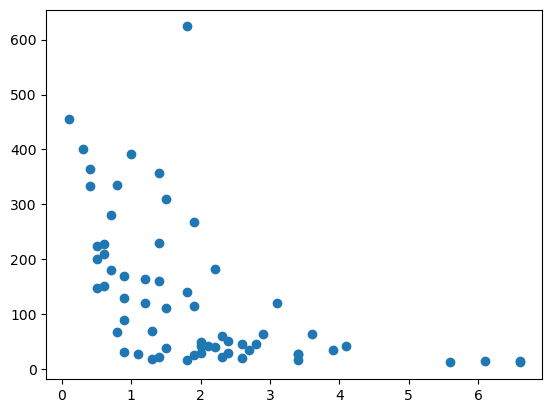

In [53]:
plt.scatter(df["Dreaming"], df["Gestation"])

In [54]:
corr_func("Dreaming",0.5)
kendal_corr = df["Dreaming"].corr(df["Gestation"], method="kendall")
print("\n\n Kendall correlation coefficient is ", kendal_corr)

Correlation for Dreaming : 

 Spearman correlation is: {'TotalSleep': 0.76, 'Awake': -0.76, 'NonDreaming': 0.56, 'Gestation': -0.69, 'Exposure': -0.63, 'Danger': -0.53} 

 Pearson correlation is: {}


 Kendall correlation coefficient is  -0.5033927081768647


##### I don't understand why but the model doesn't put any weight on Gestation despite the good negative correlation between both ? So we remove gestation in the model since it has no influence. We can dig further to understand it maybe comparing with xlstat , minitab or other...

##### We tested a bunch of models and features to assess which is preferable for imputing values in Dreaming. It seems Linear regression offers the best score as far as the test was conducted. We trained it previoudly, now we use it to do the imputation.

In [55]:
df_dreaming_null = df[df['Dreaming'].isnull()]

X_test = df_dreaming_null[["TotalSleep","Exposure"]]


# Make predictions on the test set
y_imputation = model.predict(X_test)


df.loc[df["Dreaming"].isnull(),"Dreaming"] = y_imputation


In [56]:
df["Dreaming"].isna().sum()

0

##### Dreaming now has no missing values, imputation done

#### NonDreaming cleaning

In [57]:
corr_func("NonDreaming",0.000001)

Correlation for NonDreaming : 

 Spearman correlation is: {'BodyWt': -0.53, 'BrainWt': -0.53, 'TotalSleep': 0.9, 'Awake': -0.9, 'Dreaming': 0.55, 'LifeSpan': -0.4, 'Gestation': -0.56, 'Predation': -0.26, 'Exposure': -0.5, 'Danger': -0.42} 

 Pearson correlation is: {}


In [58]:
df_ndreaming_null = df[df["NonDreaming"].isnull()]
df_ndreaming_complete = df[-df["NonDreaming"].isnull()]

feature = df_ndreaming_complete[["TotalSleep","BrainWt","BodyWt","Dreaming","Gestation"]]
target = df_ndreaming_complete[["NonDreaming"]]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=3)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("mse =", mse, "r2 =", r2)



mse = 0.3742039997939509 r2 = 0.9659470920843806


##### We get a very high R2 = 0.96 for seed n =3 which is good, it must be checked nevertheless (especially overfitting case since we used quite a lot regression imputation)

In [59]:
# Now we will to the regression imputation

x = df_ndreaming_null[["TotalSleep","BrainWt","BodyWt","Dreaming","Gestation"]]

y_imputation = model.predict(x)

df.loc[df["NonDreaming"].isnull(),"NonDreaming"] = y_imputation

In [60]:
df["NonDreaming"].isna().sum()

0

In [61]:
df["Dreaming"] = df["Dreaming"].round(2)
df["NonDreaming"] = df["NonDreaming"].round(2)

In [62]:
df.isna().sum()

Species                0
Genus                  0
Order                  0
Conservation          29
BodyWt                 0
BrainWt                0
TotalSleep             0
Awake                  0
NonDreaming            0
Dreaming               0
LifeSpan               0
Gestation              0
Predation              0
Exposure               0
Danger                 0
Vore_herbi             0
Vore_insecti           0
Vore_omni              0
Vore                   0
Conservation_count    29
LogBrainWt             0
LogBodyWt              0
BrainBodyRatio         0
dtype: int64

##### The dataset is entirely clean except for conversation which we must fill out ourselves from sources.

In [63]:
df['LogBrainWt'] = np.log(df['BrainWt'])
df['LogBodyWt'] = np.log(df["BodyWt"])
df["BrainBodyRatio"] = df["BrainWt"] / df["BodyWt"]

### Data normalization - scaling - standardization

In [64]:
# We will standardize rather than normalize
col_std = ['BodyWt', 'BrainWt', 'TotalSleep', 'Awake', 'NonDreaming', 'Dreaming', 'LifeSpan', 'Gestation']

# scaler = StandardScaler()
scaler = MinMaxScaler()

for col in col_std:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

In [65]:
# We transform the data in the specified columns using the Johnson SB distribution

from scipy.stats import johnsonsb
import numpy as np

# df is our DataFrame and col_std is our list of columns to transform

for col in col_std:
    # Fit Johnson SB distribution to the data
    params = johnsonsb.fit(df[col])
    
    # Transform the data using the Johnson SB distribution
    df[col] = johnsonsb(*params).cdf(df[col])




##### # DF should contains only standardize data now, we will check.

In [66]:
scaled = {}
for col in col_std:
    mean = df[col].mean()
    std = df[col].std()
    scaled[col] = [mean,std]

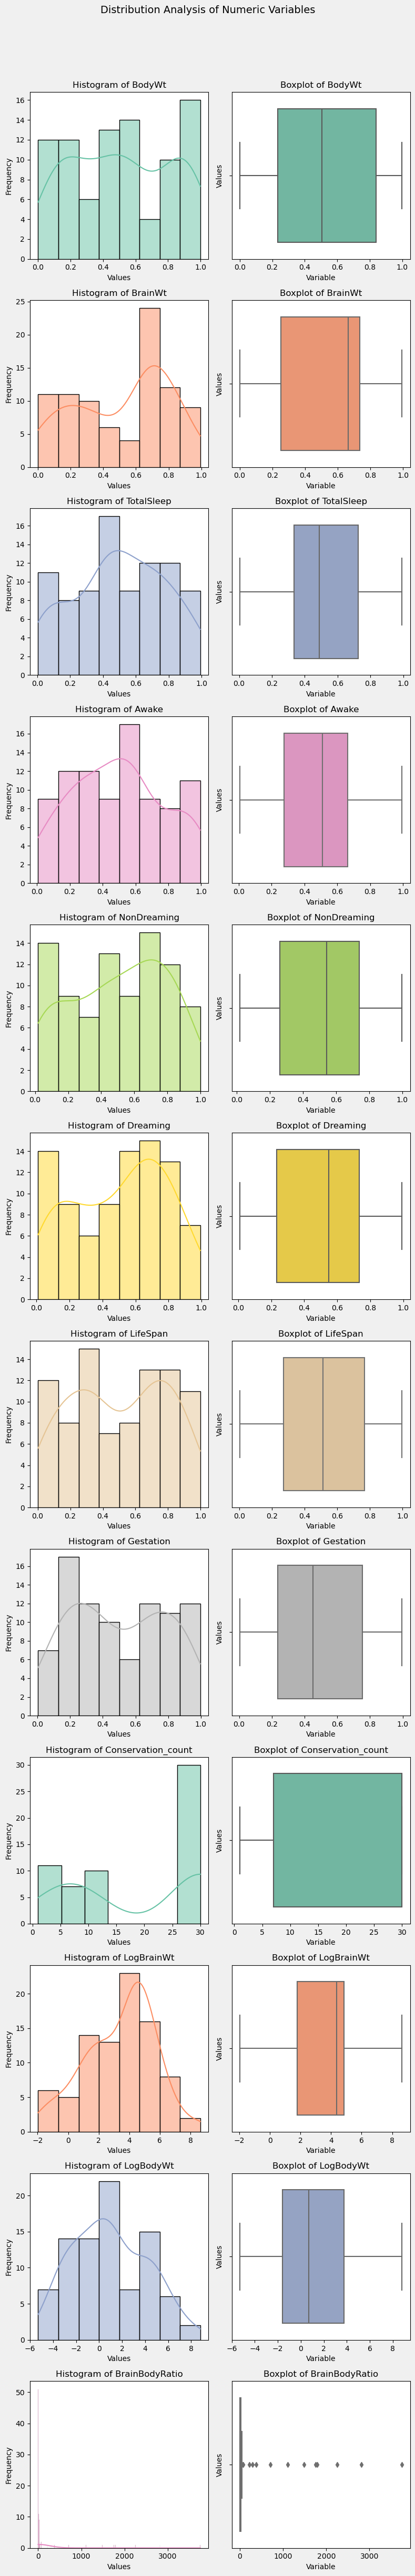

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric columns to plot
numeric_cols = [col for col in df.columns if df[col].dtype in ["float64", "int64"] and col not in ['Predation', 'Exposure', 'Danger']]

# Define a color palette for the plots
color_palette = sns.color_palette("Set2", len(numeric_cols))

# Create a figure for the subplots with a smaller size and non-white background
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(8, 4 * len(numeric_cols)))  # Adjust figsize
fig.set_facecolor('#f0f0f0')  # Set background color to light gray

for i, col in enumerate(numeric_cols):
    # Plot the histogram on the left (first column)
    sns.histplot(data=df, x=col, bins="auto", kde=True, ax=axes[i, 0], color=color_palette[i])
    axes[i, 0].set_title(f"Histogram of {col}")
    axes[i, 0].set_xlabel("Values")
    axes[i, 0].set_ylabel("Frequency")
    
    # Plot the boxplot on the right (second column)
    sns.boxplot(data=df, x=col, ax=axes[i, 1], color=color_palette[i])
    axes[i, 1].set_title(f"Boxplot of {col}")
    axes[i, 1].set_xlabel("Variable")
    axes[i, 1].set_ylabel("Values")

# Add a title to the entire figure
plt.suptitle("Distribution Analysis of Numeric Variables", fontsize=14, y=1.02)  # Adjust fontsize

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Seems like it's well standardize.

## Saving File - Data cleaned

In [68]:
df = df.sort_values(by="Species", ascending=True)
df.to_csv("sleep_merged.csv", index=False)

# MODELLING

In [70]:
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from scipy.stats import anderson, kstest, shapiro

#### Loading working file

In [69]:
file = "cleaned_sleep_merged.csv"

data = pd.read_csv(file)

df = copy.deepcopy(data)

#### Model selection

In [70]:
# Feature Selection based on f_regression
features = ['Gestation', 'Exposure', 'LifeSpan', 'Danger', 'BrainWt', 'BodyWt', 'Vore_herbi', 'Vore_insecti','Vore_omni', 'Predation']
X = df[features]
y_total_sleep = df['TotalSleep']
y_dreaming = df['Dreaming']

# Initialize dictionaries to store the cumulative MSE and R2 scores for averaging
cumulative_results_dreaming = {"Linear Regression": {"MSE": [], "R2": []},
                               "Random Forest": {"MSE": [], "R2": []},
                               "Gradient Boosting": {"MSE": [], "R2": []},
                               "SVR" : {"MSE" : [], "R2": []},
                               "KNN-Regressor": {"MSE" : [], "R2": []}}

cumulative_results_total_sleep = {"Linear Regression": {"MSE": [], "R2": []},
                                  "Random Forest": {"MSE": [], "R2": []},
                                  "Gradient Boosting": {"MSE": [], "R2": []},
                                  "SVR" : {"MSE" : [], "R2": []},
                                  "KNN-Regressor": {"MSE" : [], "R2": []}}

def model_apply(X_train, X_test, y_train, y_test, cumulative_results, target: str):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        cumulative_results[name]["MSE"].append(mse)
        cumulative_results[name]["R2"].append(r2)
        
        if name == "Linear Regression":
            # Coefficients for Linear Regression
            coef_abs = np.abs(model.coef_)
            max_indices = np.argsort(coef_abs)[::-1][:3]  # Select indices of top 3 features
            print(f"\nTop 3 predictors for {name} - Target feature: {target}")
            for idx in max_indices:
                print(f"{features[idx]}: {model.coef_[idx]}")
                
        elif name == "Random Forest":
            # Feature importances for Random Forest
            importances = model.feature_importances_
            max_indices = np.argsort(importances)[::-1][:3]  # Select indices of top 3 features
            print(f"\nTop 3 predictors for {name} - Target feature: {target}")
            for idx in max_indices:
                print(f"{features[idx]}: {importances[idx]}")
        
    return cumulative_results

# We pick a seed
random_state = 11
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=random_state),
    "Gradient Boosting": GradientBoostingRegressor(random_state=random_state),
    "SVR": SVR(),
    "KNN-Regressor" : KNeighborsRegressor()
}

# Splitting the dataset for both targets
X_train_total_sleep, X_test_total_sleep, y_train_total_sleep, y_test_total_sleep = train_test_split(X, y_total_sleep, test_size=0.2, random_state=random_state)
X_train_dreaming, X_test_dreaming, y_train_dreaming, y_test_dreaming = train_test_split(X, y_dreaming, test_size=0.2, random_state=random_state)

cumulative_results_dreaming = model_apply(X_train_dreaming, X_test_dreaming, y_train_dreaming, y_test_dreaming, cumulative_results_dreaming, "Dreaming")
cumulative_results_total_sleep = model_apply(X_train_total_sleep, X_test_total_sleep, y_train_total_sleep, y_test_total_sleep, cumulative_results_total_sleep, "TotalSleep")

# Calculate and print the mean MSE and R2 for each model
def print_mean_results(cumulative_results, title):
    print(f"\n Results for {title}:")
    for model, metrics in cumulative_results.items():
        mean_mse = np.mean(metrics["MSE"])
        mean_r2 = np.mean(metrics["R2"])
        print(f"{model} - MSE: {mean_mse:.4f}, R2: {mean_r2:.4f}")

print_mean_results(cumulative_results_dreaming, "Target - Dreaming")
print_mean_results(cumulative_results_total_sleep, "Target - Total Sleep")



Top 3 predictors for Linear Regression - Target feature: Dreaming
Gestation: -0.7255955618152082
BrainWt: 0.2215747137422358
Danger: -0.15241147064530763

Top 3 predictors for Random Forest - Target feature: Dreaming
Gestation: 0.6354204139914904
LifeSpan: 0.10078920878948916
Danger: 0.07072958006395773

Top 3 predictors for Linear Regression - Target feature: TotalSleep
Gestation: -0.5524055074879046
BodyWt: -0.21315142294598238
LifeSpan: 0.17941954154416054

Top 3 predictors for Random Forest - Target feature: TotalSleep
Gestation: 0.5829300066523078
BodyWt: 0.14330389575717434
LifeSpan: 0.07006201891178389

 Results for Target - Dreaming:
Linear Regression - MSE: 0.0395, R2: 0.5549
Random Forest - MSE: 0.0396, R2: 0.5535
Gradient Boosting - MSE: 0.0500, R2: 0.4365
SVR - MSE: 0.0400, R2: 0.5485
KNN-Regressor - MSE: 0.0403, R2: 0.5453

 Results for Target - Total Sleep:
Linear Regression - MSE: 0.0705, R2: 0.3194
Random Forest - MSE: 0.0411, R2: 0.6036
Gradient Boosting - MSE: 0.0485

In [71]:
results_dreaming = pd.DataFrame(cumulative_results_dreaming)
results_totalsleep = pd.DataFrame(cumulative_results_total_sleep)

## Model justification

### Residual Analysis for Linear Regression

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [73]:
data = copy.deepcopy(df)

In [74]:
# 'TotalSleep' as target and other columns are features
X = data[['LogBodyWt', 'LogBrainWt', 'BrainBodyRatio','Gestation','Danger','LifeSpan']]  # Include other relevant features
y = data['TotalSleep']

In [75]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
# Initialize the model
model = LinearRegression()

In [77]:
# Fit the model on the training data
model.fit(X_train, y_train)

LinearRegression()

In [78]:
# Predict on the test data
y_pred = model.predict(X_test)

In [79]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [80]:
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.04479340153041583
R^2 Score: 0.5091162872119999


In [81]:
min_sleep = data['TotalSleep'].min()
max_sleep = data['TotalSleep'].max()

print(f"Minimum Total Sleep: {min_sleep} hours")
print(f"Maximum Total Sleep: {max_sleep} hours")

Minimum Total Sleep: 0.0031524623746718 hours
Maximum Total Sleep: 0.9942372571031516 hours


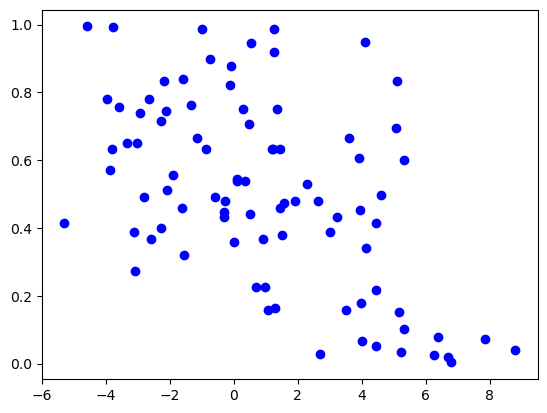

In [82]:
# 'data' is the DataFrame and 'model' is the trained LinearRegression model

# Scatter plot of the actual data
plt.scatter(data['LogBodyWt'], data['TotalSleep'], color='blue', label='Actual Data')

In [83]:
# Calculate the mean values for the other features
mean_brainbody_ratio = data['BrainBodyRatio'].mean()
mean_logbrainwt = data['LogBrainWt'].mean()
mean_lifespan = data['LifeSpan'].mean()
mean_gestation = data["Gestation"].mean()
mean_danger = data["Danger"].mean()

In [84]:
# Creating a DataFrame for predictions, ensuring the column order matches the training data
log_bodywt_range = np.linspace(data['LogBodyWt'].min(), data['LogBodyWt'].max(), 100)
prediction_df = pd.DataFrame({
    'LogBodyWt': log_bodywt_range,
    'LogBrainWt': [mean_logbrainwt] * len(log_bodywt_range),  # mean_logbrainwt defined earlier
    'BrainBodyRatio': [mean_brainbody_ratio] * len(log_bodywt_range),
    'Gestation' : [mean_gestation] * len(log_bodywt_range),
    'Danger' : [mean_danger] * len(log_bodywt_range),
        'LifeSpan' : [mean_lifespan] * len(log_bodywt_range)   # mean_brainbody_ratio defined earlie
})

In [85]:
# Predict 'TotalSleep' using the model for each value in the range
predicted_sleep = model.predict(prediction_df)

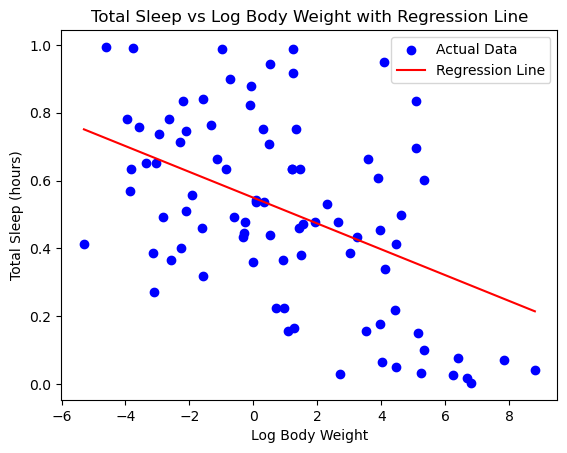

In [86]:
# Create the scatter plot
plt.scatter(data['LogBodyWt'], data['TotalSleep'], color='blue', label='Actual Data')

# Create the regression line plot
plt.plot(log_bodywt_range, predicted_sleep, color='red', label='Regression Line')

# Adding labels, title, and legend
plt.xlabel('Log Body Weight')
plt.ylabel('Total Sleep (hours)')
plt.title('Total Sleep vs Log Body Weight with Regression Line')

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [87]:
from sklearn.preprocessing import PolynomialFeatures

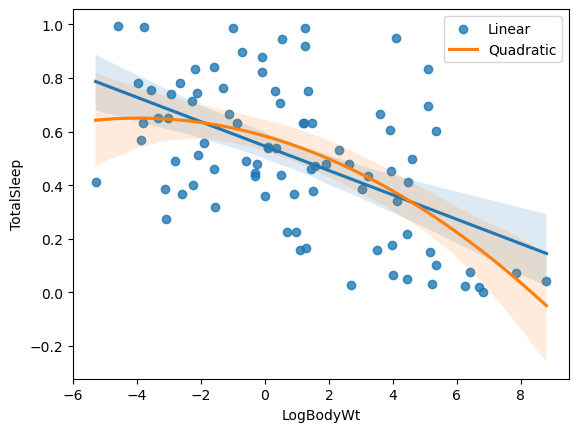

In [88]:
# Confirm that a linear relationship applies 
# Scatter plot with polynomial regression lines
sns.regplot(x='LogBodyWt', y='TotalSleep', data=data, order=1, label='Linear')
sns.regplot(x='LogBodyWt', y='TotalSleep', data=data, order=2, label='Quadratic', scatter=False)
plt.legend()
plt.show()

In [89]:
# Further test regression model using residuals analysis
residuals = y_test - y_pred

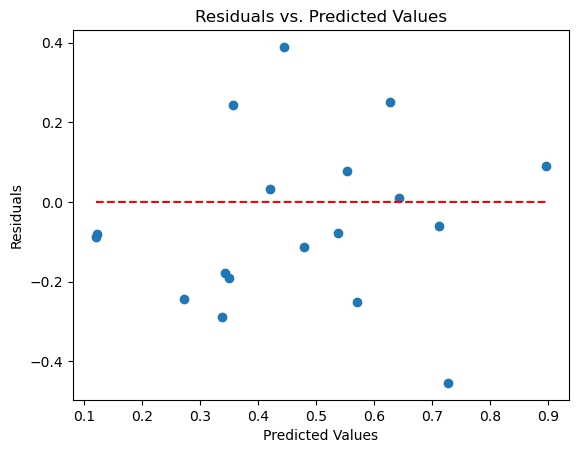

In [90]:
# Residuals vs. Predicted Values
plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

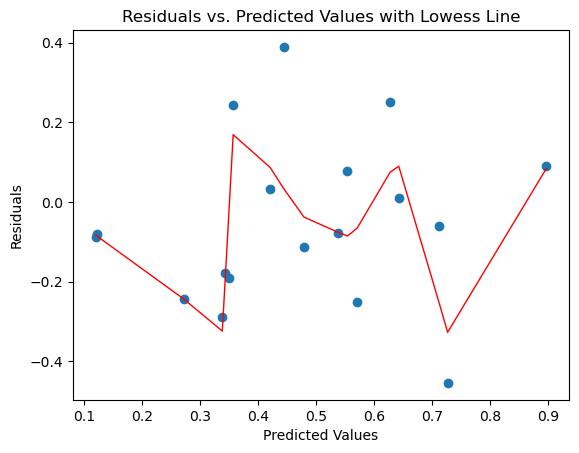

In [91]:
# Residuals vs. Predicted Values with Lowess Line
from statsmodels.nonparametric.smoothers_lowess import lowess

# Calculate lowess line
fraction = 0.3  # Fraction of data to use for smoothing
lowess_line = lowess(residuals, y_pred, frac=fraction)

# Plot
plt.scatter(y_pred, residuals)
plt.plot(lowess_line[:, 0], lowess_line[:, 1], color='red', lw=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values with Lowess Line')
plt.show()

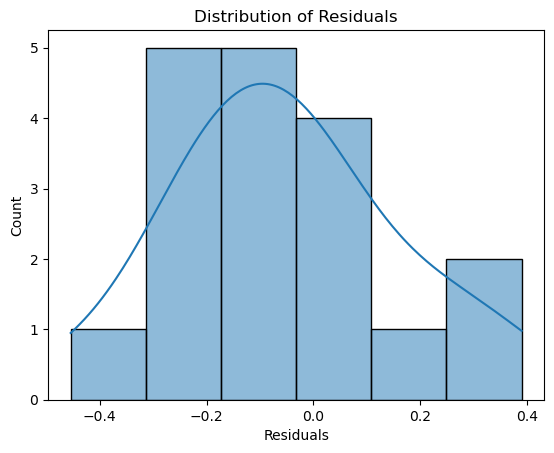

In [92]:
# Histogram of Residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

### Residual analysis for Random Forest

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# 'TotalSleep' as target and other columns are features
X = data[['LogBodyWt', 'LogBrainWt', 'BrainBodyRatio','Gestation','Danger','LifeSpan']]  # Include other relevant features
y = data['TotalSleep']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(random_state=11)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

min_sleep = data['TotalSleep'].min()
max_sleep = data['TotalSleep'].max()

print(f"Minimum Total Sleep: {min_sleep} hours")
print(f"Maximum Total Sleep: {max_sleep} hours")




Mean Squared Error: 0.05626666421417365
R^2 Score: 0.38338263913950965
Minimum Total Sleep: 0.0031524623746718 hours
Maximum Total Sleep: 0.9942372571031516 hours


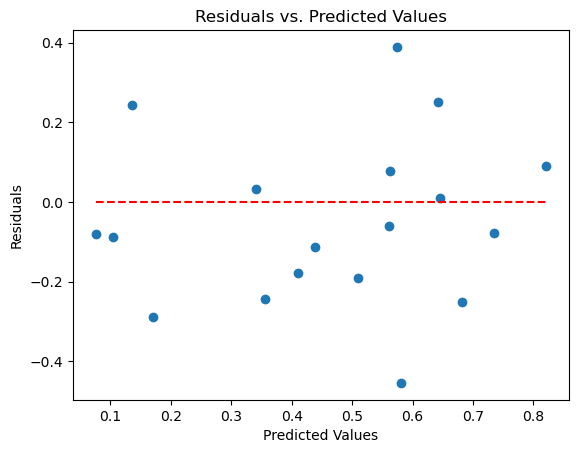

In [94]:
# Residuals vs. Predicted Values
plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

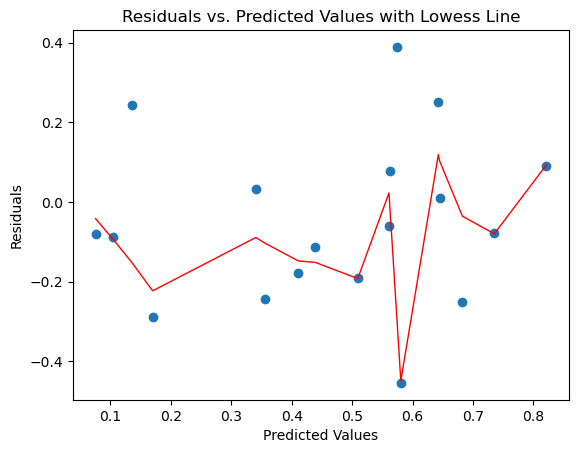

In [95]:
# Residuals vs. Predicted Values with Lowess Line
from statsmodels.nonparametric.smoothers_lowess import lowess

# Calculate lowess line
fraction = 0.3  # Fraction of data to use for smoothing
lowess_line = lowess(residuals, y_pred, frac=fraction)

# Plot
plt.scatter(y_pred, residuals)
plt.plot(lowess_line[:, 0], lowess_line[:, 1], color='red', lw=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values with Lowess Line')
plt.show()

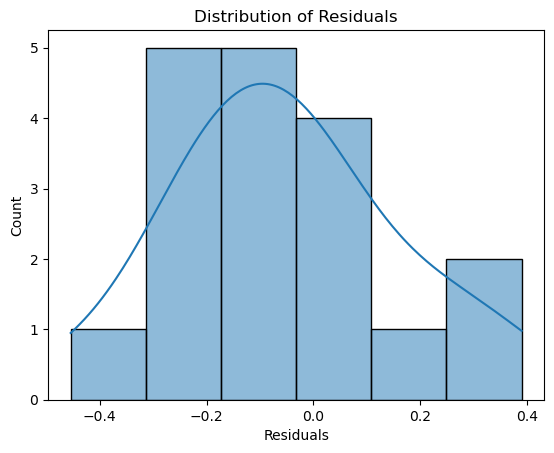

In [96]:
# Histogram of Residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()